# Scheduler for quantum gates and instructions

Author: Boxi Li (etamin1201@gmail.com)

The finite coherence time of physical qubits is one of the major factors that limits the performance of quantum computation. In principle, the execution time of the circuit has to be much shorter than the coherence time. One way to reduce this execution time is to run several gates in the circuit parallelly. This can spare a lot of time if e.g. the same single-qubit gate is applied to all qubits, as in the [Grover algorithm](https://en.wikipedia.org/wiki/Grover%27s_algorithm).

A scheduler for a quantum computer, similar to its classical counterpart, schedules a quantum circuit to minimize the execution time. It determines the order in which the gates are executed. As a simple rule, the scheduler allows gates to be executed in parallel if they do not address the same qubits. Further hardware constraints can be included, but here we only focus on this simple criterion by considering gates that do not address the same qubits. The non-trivial part of a scheduler is that it has to consider the possible permutations of commuting quantum gates. Hence, exploring various possibilities for permutation while following physical constraints of the hardware is the main challenging task for the scheduler.

We first show how we can schedule gate execution in quantum circuits using the built-in tools in `qutip_qip` and then the scheduling of compiled control pulses. In the end, we also show a simple example where the permutation of commuting gates matters in the scheduling and how to handle such situations.

In [1]:
# imports
from qutip import about
from qutip_qip.circuit import QubitCircuit
from qutip_qip.compiler import Instruction, Scheduler
from qutip_qip.device import LinearSpinChain

## Gate schedule
Let's first define a quantum circuit

/usr/share/miniconda3/envs/test-environment/lib/python3.10/site-packages/qutip_qip/circuit/circuit_latex.py:95: UserWarning: Could not locate system 'pdfcrop': image output may have additional margins.
  warnings.warn(


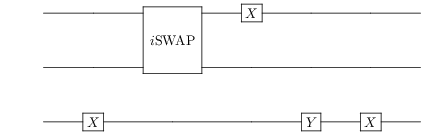

In [2]:
circuit = QubitCircuit(3)
circuit.add_gate("X", 0)
circuit.add_gate("ISWAP", targets=[1, 2])
circuit.add_gate("X", 2)
circuit.add_gate("Y", 0)
circuit.add_gate("X", 0)
circuit

This is a rather boring circuit, but it is useful as a demonstration for the scheduler. We now define a scheduler and schedule the execution of gates in the circuit

In [3]:
scheduler = Scheduler("ASAP")  # schedule as soon as possible
scheduled_time = scheduler.schedule(circuit)
scheduled_time

[0, 0, 1, 1, 2]

This result shows the scheduled starting time for each gate.
In the first cycle we execute an iSWAP on qubit 0 and 1 and an X gate on qubit 0; In the second cycle we execute one X gate on qubit 2 and one Y gate on qubit 0; In the last cycle, we execute a single X gate on qubit 0. As printed bellow:

In [4]:
cycle_list = [[] for i in range(max(scheduled_time) + 1)]

for i, time in enumerate(scheduled_time):
    gate = circuit.gates[i]
    cycle_list[time].append(gate.name + str(gate.targets))
for cycle in cycle_list:
    print(cycle)

['X[0]', 'ISWAP[1, 2]']
['X[2]', 'Y[0]']
['X[0]']


We can also schedule the gate follows the rule "as late as possible"

In [5]:
scheduler = Scheduler("ALAP")  # schedule as late as possible
scheduled_time = scheduler.schedule(circuit)
cycle_list = [[] for i in range(max(scheduled_time) + 1)]
for i, time in enumerate(scheduled_time):
    gate = circuit.gates[i]
    cycle_list[time].append(gate.name + str(gate.targets))
for cycle in cycle_list:
    print(cycle)

['X[0]']
['ISWAP[1, 2]', 'Y[0]']
['X[2]', 'X[0]']


The only difference is that the "iSWAP" gate and the X gate on qubit 2 are shifted by one cycle. 

## Instruction/Pulse schedule
Often different quantum gates will have different execution time. To consider this, we define a list of quantum instructions, where X gate has the execution time 1 while the iSWAP gate takes the time 3.5

In [6]:
scheduler = Scheduler("ASAP")
instructions = []

for gate in circuit.gates:
    if gate.name in ("X"):
        duration = 1
    elif gate.name == "ISWAP":
        duration = 3.5
    instruction = Instruction(gate, duration=duration)
    instructions.append(instruction)
scheduler.schedule(instructions)

[0, 0.0, 3.5, 1, 2]

The scheduled execution time for each gate can no longer be assigned to gate cycles. But we can see this through the [noisy circuit simulator](https://qutip-qip.readthedocs.io/en/stable/qip-processor.html) of qutip, where the circuit is compiled to control signals: (Notice that the execution time follows the hardware parameter of spin chain and the Y gate is decomposed into a Z-X-Z rotation).

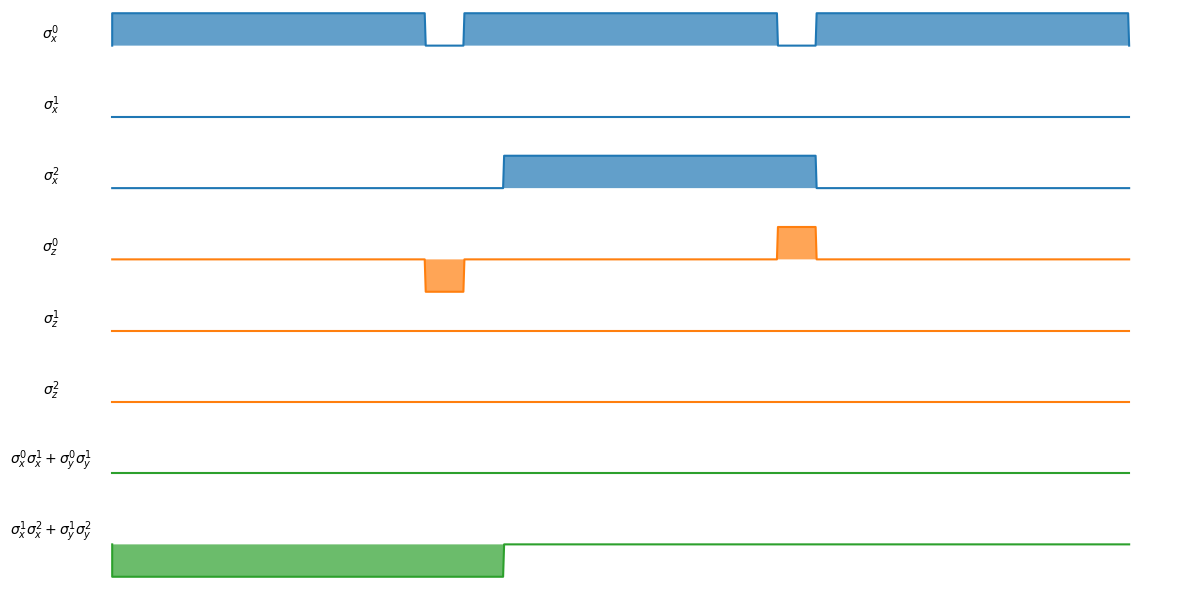

In [7]:
device = LinearSpinChain(3)
device.load_circuit(
    circuit, "ASAP"
)  # The circuit are compiled to instructions and scheduled.
device.plot_pulses();

The green and orange pulses represent rotations along the X and Z axis. The green pulse is the iSWAP gate, which is executed simultaneously with a few other single-qubit rotations on qubit 0.

## Considering commuting gates
We consider the following circuit:

/usr/share/miniconda3/envs/test-environment/lib/python3.10/site-packages/qutip_qip/circuit/circuit_latex.py:95: UserWarning: Could not locate system 'pdfcrop': image output may have additional margins.
  warnings.warn(


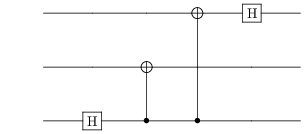

In [8]:
circuit = QubitCircuit(3)
circuit.add_gate("SNOT", 0)
circuit.add_gate("CNOT", 1, 0)
circuit.add_gate("CNOT", 2, 0)
circuit.add_gate("SNOT", 2)
circuit

At first sight, it might look like no gates can be run in parallel. However, the two CNOT gates actually commute and if we permute them, we can run one CNOT together with the last Hadamard gate.

In [9]:
scheduler = Scheduler("ALAP")
scheduled_time = scheduler.schedule(circuit)

cycle_list = [[] for i in range(max(scheduled_time) + 1)]
for i, time in enumerate(scheduled_time):
    gate = circuit.gates[i]
    cycle_list[time].append(gate.name + str(gate.targets))
for cycle in cycle_list:
    print(cycle)

['SNOT[0]']
['CNOT[2]']
['CNOT[1]', 'SNOT[2]']


## Random shuffle
The scheduling algorithm is heuristic and hence cannot always find the optimal result. Therefore randomness can be added to the scheduling process by the parameters `random_shuffle` and `repeat_num`.

In [10]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.1.0.dev0+c874c4a
Numpy Version:      1.22.4
Scipy Version:      1.13.1
Cython Version:     3.0.10
Matplotlib Version: 3.5.2
Python Version:     3.10.4
Number of CPUs:     4
BLAS Info:          Generic
INTEL MKL Ext:      False
Platform Info:      Linux (x86_64)
Installation path:  /usr/share/miniconda3/envs/test-environment/lib/python3.10/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bi